# Notebook for Traffic Volume ML

Predict traffic volume using four different machine learning models (Decision Tree, Random Forest, AdaBoost, XGBoost) based on the given features.

## Datset Cleaning and Preparation

In [2]:
# Importing libraries
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
import seaborn as sns                # Seaborn

# Packages to implement the four models
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb


# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to visualize Decision Tree
from sklearn import tree

# Package for generating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Package for generating classification report
from sklearn.metrics import classification_report

# Import packages to implement K-fold CV
from sklearn.model_selection import KFold # For creating folds

# Import Package to implement GridSearch CV (Hyperparameter Tuning Method 1)
from sklearn.model_selection import GridSearchCV

# Importing package for Randomized Search CV (Hyperparameter Tuning Method 2)
from sklearn.model_selection import RandomizedSearchCV

# Import Package for metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error # use squared=False for rmse

# Package to record time
import time

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Module to save and load Python objects to and from files
import pickle 

%matplotlib inline

# Display inline plots as vector-based (svg) or pdf
%config InlineBackend.figure_formats = ['svg']

In [30]:
# Load dataset as dataframe
traffic_df = pd.read_csv('Traffic_Volume.csv', keep_default_na=False)
traffic_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [31]:
# Drop weather description column
traffic_df = traffic_df.drop('weather_description', axis=1)

In [32]:
traffic_df['date_time'] = pd.to_datetime(traffic_df['date_time'])

# # Add columns for month, day of week, and time
# traffic_df['month'] = traffic_df['date_time'].dt.month
# traffic_df['day_of_week'] = traffic_df['date_time'].dt.dayofweek
# traffic_df['time'] = traffic_df['date_time'].dt.time

# Add a column for month name
traffic_df['month'] = traffic_df['date_time'].dt.strftime('%B')

# Add a column for day of week name
traffic_df['day_of_week'] = traffic_df['date_time'].dt.strftime('%A')

# Add a column for time
traffic_df['time'] = traffic_df['date_time'].dt.strftime('%H:%M:%S')

traffic_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume,month,day_of_week,time
0,None,288.28,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545,October,Tuesday,09:00:00
1,None,289.36,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516,October,Tuesday,10:00:00
2,None,289.58,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767,October,Tuesday,11:00:00
3,None,290.13,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026,October,Tuesday,12:00:00
4,None,291.14,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918,October,Tuesday,13:00:00


In [33]:
traffic_df =  traffic_df.drop('date_time', axis=1)

In [34]:
traffic_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,day_of_week,time
0,None,288.28,0.0,0.0,40,Clouds,5545,October,Tuesday,09:00:00
1,None,289.36,0.0,0.0,75,Clouds,4516,October,Tuesday,10:00:00
2,None,289.58,0.0,0.0,90,Clouds,4767,October,Tuesday,11:00:00
3,None,290.13,0.0,0.0,90,Clouds,5026,October,Tuesday,12:00:00
4,None,291.14,0.0,0.0,75,Clouds,4918,October,Tuesday,13:00:00


In [35]:
# Output column for prediction
output = traffic_df['traffic_volume'] 

# Input features (excluding year column)
features = traffic_df[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'month', 'day_of_week', 'time']] 

# One-hot-encoding for categorical variables
features = pd.get_dummies(features)


In [36]:
features.head()

,temp,rain_1h,snow_1h,clouds_all,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,time_14:00:00,time_15:00:00,time_16:00:00,time_17:00:00,time_18:00:00,time_19:00:00,time_20:00:00,time_21:00:00,time_22:00:00,time_23:00:00
0,288.28,0.0,0.0,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [37]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 70 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   temp                               48204 non-null  float64
 1   rain_1h                            48204 non-null  float64
 2   snow_1h                            48204 non-null  float64
 3   clouds_all                         48204 non-null  int64  
 4   holiday_Christmas Day              48204 non-null  bool   
 5   holiday_Columbus Day               48204 non-null  bool   
 6   holiday_Independence Day           48204 non-null  bool   
 7   holiday_Labor Day                  48204 non-null  bool   
 8   holiday_Martin Luther King Jr Day  48204 non-null  bool   
 9   holiday_Memorial Day               48204 non-null  bool   
 10  holiday_New Years Day              48204 non-null  bool   
 11  holiday_None                       48204 non-null  boo

In [38]:
# Data partitioning into training and testing
train_X, test_X, train_y, test_y = train_test_split(features, output, test_size = 0.2, random_state = 1) 

## Decision Tree

In [12]:
# Define the prediction model
clr = DecisionTreeRegressor(random_state = 0)

# Ranges for hyperparameters
hyper_params_random = {
    'max_depth': list(range(5, 30)),
    'min_samples_leaf': list(range(5, 30)),
    'min_samples_split': list(range(5, 30))
}
# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

In [162]:
# Create the random search CV
random_model_cv = RandomizedSearchCV(estimator = clr,
                                     param_distributions = hyper_params_random,
                                     scoring = 'r2',
                                     cv = folds,
                                     verbose = 1,
                                     n_jobs = -1,
                                     n_iter = 100, #number of combinations we will test the model on
                                     random_state = 100) #set seed to select same 100 samples


# Fit the model
start = time.time()            # Start Time
random_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training time: 16.83809494972229s


In [163]:
# Return set of parameters with the best performance
print(random_model_cv.best_params_)

# Return the performance metric score
print(random_model_cv.best_score_)

{'min_samples_split': 11, 'min_samples_leaf': 27, 'max_depth': 26}
0.9367959840654884


In [164]:
# Now implement GridSearch
# Your code
hyper_params_optimal = {
    'max_depth': list(range(23, 29)),
    'min_samples_leaf': list(range(24, 30)),
    'min_samples_split': list(range(6, 12))
}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = clr,
                        param_grid = hyper_params_optimal,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

start = time.time()            # Start Time
model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Training time: 37.662445068359375s


In [165]:
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Improved score:  0.9371869951279154
Improved parameters:  {'max_depth': 28, 'min_samples_leaf': 28, 'min_samples_split': 6}


In [39]:
# Fit the best tree
clr = DecisionTreeRegressor(random_state = 0, max_depth=28, min_samples_leaf=28, min_samples_split=6)
clr.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=28, min_samples_leaf=28, min_samples_split=6,
                      random_state=0)

In [40]:
# Predictions on test set
y_pred = clr.predict(test_X)

# Return r2
print("R2: ", r2_score(test_y, y_pred))

R2:  0.9429108713392104


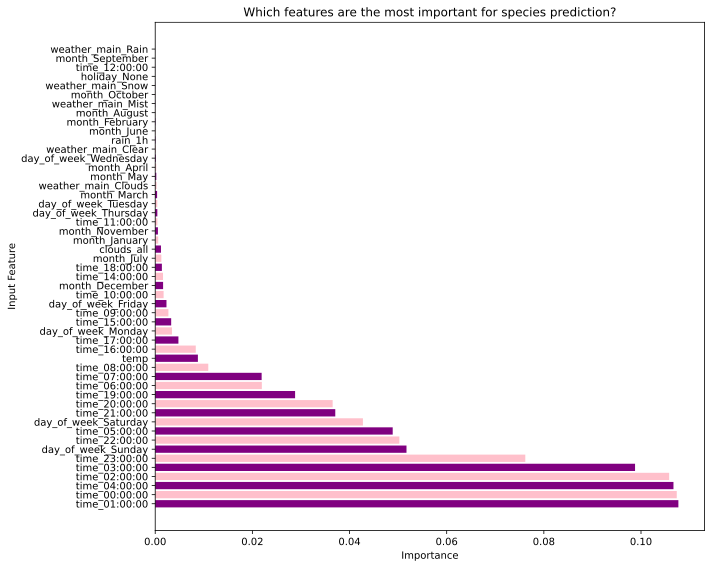

In [41]:
# Storing importance values from the trained model
importance = clr.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

# Selecting features with non-zero importance values
feature_imp = feature_imp[feature_imp['Importance'] != 0.0]

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['purple', 'pink'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.title('Which features are the most important for species prediction?') 
plt.tight_layout();
plt.savefig("dt_feature_imp.svg")

### Pickle DT Model

In [43]:
# First pickle file: saving the trained DT model
# Creating the file where we want to write the model
dt_pickle = open('dt_traffic.pickle', 'wb') 

# Write DT model to the file
pickle.dump(clr, dt_pickle) 

# Close the file
dt_pickle.close() 

# # Second pickle file: uniques variable, which maps the 
# # factorized output variable to the species name that we recognize
# output_pickle = open('dt_output_traffic.pickle', 'wb') 
# pickle.dump(output, output_pickle) 
# output_pickle.close() 

## Random Forest

In [170]:
# Define the prediction model
clr_rf = RandomForestRegressor(random_state = 42)

# Ranges for hyperparameters
hyper_params_new = {
    'max_depth': list(range(2, 30)),
    'min_samples_leaf': list(range(2, 30)),
    'min_samples_split': list(range(2, 30)),
    'n_estimators': [200, 300, 400, 500, 600, 700, 800]
}

# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

In [171]:
# Create the random search CV
random_model_cv = RandomizedSearchCV(estimator = clr_rf,
                                     param_distributions = hyper_params_new,
                                     scoring = 'r2',
                                     cv = folds,
                                     verbose = 1,
                                     n_jobs = -1,
                                     n_iter = 100, #number of combinations we will test the model on
                                     random_state = 100) #set seed to select same 100 samples


# Fit the model
start = time.time()            # Start Time
random_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training time: 1970.0560760498047s


In [173]:
# Return set of parameters with the best performance
print(random_model_cv.best_params_)

# Return the performance metric score
print(random_model_cv.best_score_)

{'n_estimators': 600, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 29}
0.9439124892940042


In [176]:
# Now implement GridSearch
# Your code
hyper_params_optimal = {
    'max_depth': list(range(27, 31)),
    'min_samples_leaf': list(range(2, 4)),
    'min_samples_split': list(range(2, 6)),
    'n_estimators': [700, 800, 900]
    
}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = clr_rf,
                        param_grid = hyper_params_optimal,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

start = time.time()            # Start Time
model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 96 candidates, totalling 288 fits


Training time: 4663.182460069656s


In [177]:
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Improved score:  0.9442628262370175
Improved parameters:  {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 700}


In [44]:
# Fit the best tree
clr_rf = RandomForestRegressor(random_state = 42, max_depth=30, min_samples_leaf=3, min_samples_split=2, n_estimators=700)
clr_rf.fit(train_X, train_y)

RandomForestRegressor(max_depth=30, min_samples_leaf=3, n_estimators=700,
                      random_state=42)

In [45]:
# Predictions on test set
y_pred = clr_rf.predict(test_X)

# Return r2
print("R2: ", r2_score(test_y, y_pred))

R2:  0.9496346653308734


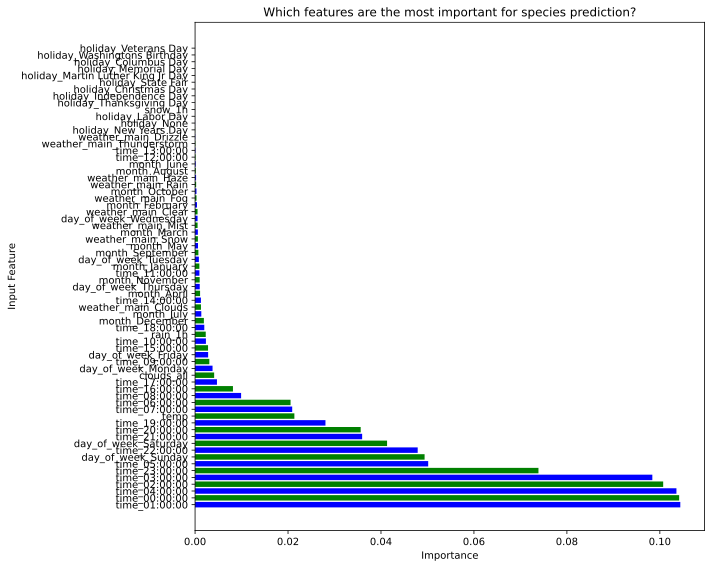

In [46]:
# Storing importance values from the trained model
importance = clr_rf.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

# Selecting features with non-zero importance values
feature_imp = feature_imp[feature_imp['Importance'] != 0.0]

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['blue', 'green'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.title('Which features are the most important for species prediction?') 
plt.tight_layout();
plt.savefig("rf_feature_imp.svg")

### Pickle RF Model

In [47]:
# First pickle file: saving the trained RF model
# Creating the file where we want to write the model
rf_pickle = open('rf_traffic.pickle', 'wb') 

# Write DT model to the file
pickle.dump(clr_rf, rf_pickle) 

# Close the file
rf_pickle.close() 

## AdaBoost

In [204]:
# Define the prediction model
clr_ada = AdaBoostRegressor(random_state = 100)

# Ranges for hyperparameters
hyper_params_random = {
    'n_estimators': list(range(25, 75)),
    'learning_rate': list(range(0, 10)),
    'loss': ["linear", "square", "exponential"]
}
# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

In [205]:
# Create the random search CV
random_model_cv = RandomizedSearchCV(estimator = clr_ada,
                                     param_distributions = hyper_params_random,
                                     scoring = 'r2',
                                     cv = folds,
                                     verbose = 1,
                                     n_jobs = -1,
                                     n_iter = 100, #number of combinations we will test the model on
                                     random_state = 100) #set seed to select same 100 samples


# Fit the model
start = time.time()            # Start Time
random_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Training time: 281.4583020210266s


In [206]:
# Return set of parameters with the best performance
print(random_model_cv.best_params_)

# Return the performance metric score
print(random_model_cv.best_score_)

{'n_estimators': 70, 'loss': 'exponential', 'learning_rate': 6}
0.5682619721107337


In [208]:
# Now implement GridSearch
# Your code
hyper_params_optimal = {
    'n_estimators': list(range(65, 75)),
    'learning_rate': list(range(4, 8)),
    'loss': ["linear", "square", "exponential"]
    
}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = clr_ada,
                        param_grid = hyper_params_optimal,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

start = time.time()            # Start Time
model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Training time: 498.70108819007874s


In [209]:
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Improved score:  0.5682619721107337
Improved parameters:  {'learning_rate': 6, 'loss': 'exponential', 'n_estimators': 70}


In [48]:
# Fit the best tree
clr_ada = AdaBoostRegressor(random_state = 100, learning_rate=6, loss='exponential', n_estimators=70)
clr_ada.fit(train_X, train_y)

AdaBoostRegressor(learning_rate=6, loss='exponential', n_estimators=70,
                  random_state=100)

In [49]:
# Predictions on test set
y_pred = clr_ada.predict(test_X)

# Return r2
print("R2: ", r2_score(test_y, y_pred))

R2:  0.5361745637131226


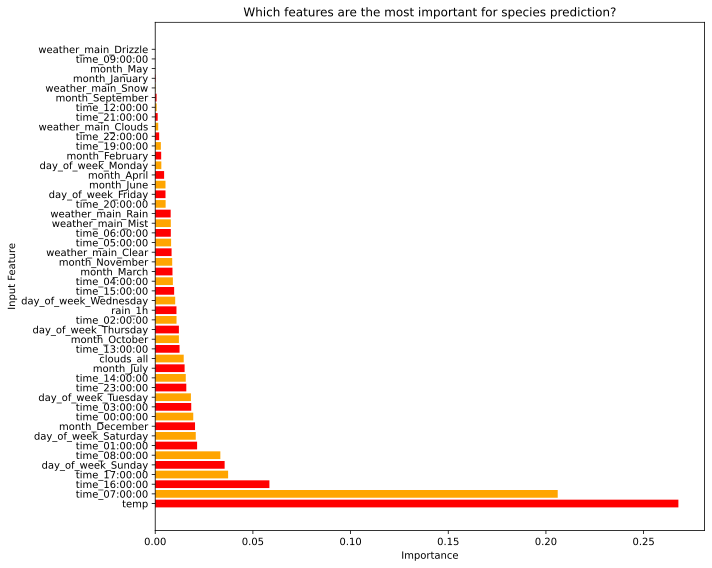

In [50]:
# Storing importance values from the trained model
importance = clr_ada.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

# Selecting features with non-zero importance values
feature_imp = feature_imp[feature_imp['Importance'] != 0.0]

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'orange'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.title('Which features are the most important for species prediction?') 
plt.tight_layout();
plt.savefig("ada_feature_imp.svg")

### Pickle AdaBoost Model

In [51]:
# First pickle file: saving the trained RF model
# Creating the file where we want to write the model
ada_pickle = open('ada_traffic.pickle', 'wb') 

# Write DT model to the file
pickle.dump(clr_ada, ada_pickle) 

# Close the file
ada_pickle.close() 

## XGBoost

In [14]:
# Define the prediction model
clr_xgb = xgb.XGBRegressor(random_state = 100)

# Ranges for hyperparameters
hyper_params_random = {
    'max_depth': list(range(5,30)),
    'n_estimators': list(range(25, 75)),
    'learning_rate': [0.1, 0.3, 0.5]
}
# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

In [15]:
# Create the random search CV
random_model_cv = RandomizedSearchCV(estimator = clr_xgb,
                                     param_distributions = hyper_params_random,
                                     scoring = 'r2',
                                     cv = folds,
                                     verbose = 1,
                                     n_jobs = -1,
                                     n_iter = 100, #number of combinations we will test the model on
                                     random_state = 100) #set seed to select same 100 samples


# Fit the model
start = time.time()            # Start Time
random_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [229]:
# Return set of parameters with the best performance
print(random_model_cv.best_params_)

# Return the performance metric score
print(random_model_cv.best_score_)

{'n_estimators': 64, 'max_depth': 8, 'learning_rate': 0.3}
0.9471948396839965


In [230]:
# Now implement GridSearch
# Your code
hyper_params_optimal = {
    'n_estimators': list(range(60, 68)),
    'max_depth': list(range(5,11)),
    'learning_rate': [0.2, 0.3, 0.4]
    
}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = clr_xgb,
                        param_grid = hyper_params_optimal,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

start = time.time()            # Start Time
model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Training time: 388.7507801055908s


In [231]:
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Improved score:  0.9471978868032339
Improved parameters:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 67}


In [52]:
# Fit the best tree
clr_xgb = xgb.XGBRegressor(random_state = 100, learning_rate=0.3, n_estimators=67, max_depth=8)
clr_xgb.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=67, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [53]:
# Predictions on test set
y_pred = clr_xgb.predict(test_X)

# Return r2
print("R2: ", r2_score(test_y, y_pred))

R2:  0.9511831238788471


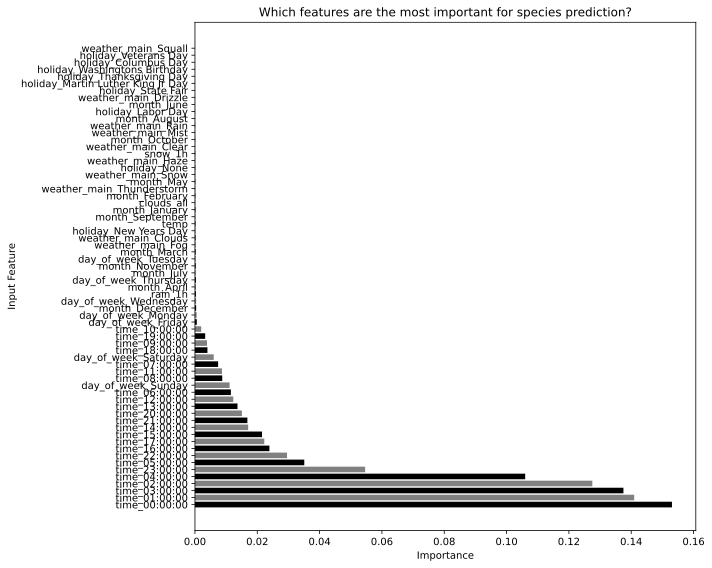

In [54]:
# Storing importance values from the trained model
importance = clr_xgb.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

# Selecting features with non-zero importance values
feature_imp = feature_imp[feature_imp['Importance'] != 0.0]

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['black', 'gray'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.title('Which features are the most important for species prediction?') 
plt.tight_layout();
plt.savefig("xgb_feature_imp.svg")

### Pickle XGBoost Model

In [55]:
# First pickle file: saving the trained RF model
# Creating the file where we want to write the model
xgb_pickle = open('xgb_traffic.pickle', 'wb') 

# Write DT model to the file
pickle.dump(clr_xgb, xgb_pickle) 

# Close the file
xgb_pickle.close() 